# Imports

In [239]:
# Importing the required packages
from tqdm import tqdm
import datetime
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import time, sys

# Data Files

In [2]:
# importing the data 
RF_Data = pd.read_csv("C:\\Users\\Ritvik Bale\\Documents\\Systemic Risk Research\\Risk Factor Data v1.csv")
Bank_Data = pd.read_csv("C:\\Users\\Ritvik Bale\\Documents\\Systemic Risk Research\\Bank data v1 2020-08-24.csv")

# converting the raw data to DataFrames
RF_Data = pd.DataFrame(RF_Data)
Bank_Data = pd.DataFrame(Bank_Data)

# Adding Year, Month, and Day Columns to the DataFrames

In [128]:
#Adding Year, Month, and Day columns to the BankData Dataframe 
#This makes it easier to access the specific rows that we want

#Initializing the arrays that will store the Year, Month, and Day of all the rows in the BankData DataFrame
Year = []
Month = []
Day = []

for i in Bank_Data["date"]:    
    #Getting the Year, Month, and Day for each row in BankData DataFrame
    Year.append((datetime.datetime.strptime(str(i), "%Y%m%d")).year)
    Month.append((datetime.datetime.strptime(str(i), "%Y%m%d")).month)
    Day.append((datetime.datetime.strptime(str(i), "%Y%m%d")).day)
    
#Adding the Year, Month, and Day arrays as columns to the BankData DataFrame
Bank_Data["Year"] = Year
Bank_Data["Month"] = Month
Bank_Data["Day"] = Day

#Dropping Rows with Null Return Values
Bank_Data = Bank_Data.dropna(axis=0, subset=['RET'])
#Dropping Rows with values B and C
Bank_Data.drop(Bank_Data[Bank_Data.RET == 'B'].index, inplace=True)
Bank_Data.drop(Bank_Data[Bank_Data.RET == 'C'].index, inplace=True)
#Converting the Return Column to type Float
Bank_Data["RET"].astype(str).astype(float)

In [150]:
Bank_Data.drop(Bank_Data[Bank_Data.RET == 'B'].index, inplace=True)
Bank_Data.drop(Bank_Data[Bank_Data.RET == 'C'].index, inplace=True)
Bank_Data["RET"].astype(str).astype(float)

0       -0.082353
1       -0.174359
2        0.125000
3       -0.062500
4       -0.045926
           ...   
35829   -0.020362
35830   -0.041701
35831    0.064621
35832    0.000409
35833   -0.019877
Name: RET, Length: 35319, dtype: float64

In [151]:
#Adding Year, Month, and Day columns to the RiskFactor Dataframe 
#This makes it easier to access the specific rows that we want

#Initializing the arrays that will store the Year, Month, and Day of all the rows in the RiskFactor DataFrame
Year = []
Month = []
Day = []

for i in RF_Data["Date"]:    
    #Getting the Year, Month, and Day for each row in the RiskFactor DataFrame
    Year.append((datetime.datetime.strptime(i, "%Y-%m-%d")).year)
    Month.append((datetime.datetime.strptime(i, "%Y-%m-%d")).month)
    Day.append((datetime.datetime.strptime(i, "%Y-%m-%d")).day)
    
#Adding the Year, Month, and Day arrays as columns to the RiskFactor DataFrame
RF_Data["Year"] = Year
RF_Data["Month"] = Month
RF_Data["Day"] = Day

In [152]:
#First few rows of BankData DataFrame
Bank_Data.head()

,PERMNO,date,SICCD,COMNAM,PERMCO,CUSIP,RET,Year,Month,Day
0,10071,19920331,6211,ALEX BROWN INC,8015,1390210,-0.082353,1992,3,31
1,10071,19920430,6211,ALEX BROWN INC,8015,1390210,-0.174359,1992,4,30
2,10071,19920529,6211,ALEX BROWN INC,8015,1390210,0.125,1992,5,29
3,10071,19920630,6211,ALEX BROWN INC,8015,1390210,-0.0625,1992,6,30
4,10071,19920731,6211,ALEX BROWN INC,8015,1390210,-0.045926,1992,7,31


In [153]:
#First few rows of RiskFactor DataFrame
RF_Data.head()

,Date,BOND,CREDIT,SP500,CMDTY,DVIX,DHOUSE,Unnamed: 7,Year,Month,Day
0,1975-02-01,0.0388,-14.02,0.1386,-0.1654,-3.8780,0.0024,NaN,1975,2,1
1,1975-03-01,0.0157,-12.54,0.0702,-0.1036,-1.6952,0.0004,NaN,1975,3,1
2,1975-04-01,-0.0142,-12.71,-0.0014,0.0908,-0.3795,-0.0012,NaN,1975,4,1
3,1975-05-01,-0.0093,-12.02,0.0691,-0.0435,-1.0668,0.0004,NaN,1975,5,1
4,1975-06-01,0.0120,-12.81,0.0538,-0.0270,-0.9265,0.0008,NaN,1975,6,1


# Initializing the Return Table

In [154]:
#Initializing the Return_Table that will consist of all the Bank Returns, and the corresponding Risk Factor Returns
Return_Table = []
Return_Table = pd.DataFrame(Return_Table)

#Adding Columns for the Year, Month, and Day (allows us to easily retrieve the corresponding Risk Factor Returns (by date))
Return_Table["Year"] = Bank_Data["Year"]
Return_Table["Month"] = Bank_Data["Month"]
Return_Table["Day"] = Bank_Data["Day"]

#Adding a PERMNO column(to be able to identify the firms), and a column consisting of all the Bank Returns
Return_Table["PERMNO"] = Bank_Data["PERMNO"]
Return_Table["Return"] = Bank_Data["RET"]

### Adding the Risk Factor Returns to the Return Table

In [155]:
#Initializing a Return Array for each Risk Factor
BOND = []
CREDIT = []
SP500 = []
CMDTY = []
DVIX = []
DHOUSE = []

In [156]:
#Adding all the corresponding Risk Factor Return values for each Bank Return entry (by date)
#Looping through the Bank Data DataFrame to find the Risk Factor returns for each date
for index, i in Bank_Data.iterrows():
    
    #Determining the year and month of row
    year = RF_Data["Year"] == i["Year"]
    month = RF_Data["Month"] == i["Month"]
    
    #Determining the row of Risk Factor Returns for the given date (year & month)
    Value = RF_Data[year & month]
    
    #Appending the Risk Factor Returns for the given date (year & month)
    BOND.append(np.array(Value["BOND"]))
    CREDIT.append(np.array(Value["CREDIT"]))
    SP500.append(np.array(Value["SP500"]))
    CMDTY.append(np.array(Value["CMDTY"]))
    DVIX.append(np.array(Value["DVIX"]))
    DHOUSE.append(np.array(Value["DHOUSE"]))

In [157]:
#Adding all of the Corresponding Risk Factor Return Arrays to the DataFrame
Return_Table["BOND"] = BOND
Return_Table["CREDIT"] = CREDIT
Return_Table["SP500"] = SP500
Return_Table["CMDTY"] = CMDTY
Return_Table["DVIX"] = DVIX
Return_Table["DHOUSE"] = DHOUSE

In [158]:
#First few rows of ReturnTable DataFrame
Return_Table.head()

,Year,Month,Day,PERMNO,Return,BOND,CREDIT,SP500,CMDTY,DVIX,DHOUSE
0,1992,3,31,10071,-0.082353,[-0.0015],[-3.676],[0.0106],[-0.0237],[-0.5],[0.0016]
1,1992,4,30,10071,-0.174359,[-0.0124],[-3.344],[-0.0178],[0.0306],[-0.65],[0.0009]
2,1992,5,29,10071,0.125,[-0.0006],[-3.179],[0.022],[0.0231],[-1.67],[0.0007]
3,1992,6,30,10071,-0.0625,[0.0066],[-3.319],[0.0159],[0.0243],[-0.51],[-0.0008]
4,1992,7,31,10071,-0.045926,[0.0078],[-3.212],[-0.0084],[-0.0041],[-0.18],[-0.0008]


# Coefficient (Beta) DataFrame Creation

In [198]:
#Creating an array consisting of all the PERMNO Codes (each code is only counted once - unique)
PERMNO = Bank_Data["PERMNO"].unique()

#Creating the Coefficient Table DataFrame which will contain the coefficients from all of the regressions
Coefficient_Table = []

In [199]:
def DateFunction(start_year, end_year):
    
    #Iterate over all firms
    for i in PERMNO:
        #Create a Return table for each firm - consisting of only the dates that have been specified
        Single_Firm = Return_Table.loc[Return_Table['PERMNO'] == i]
        
        #Modifying the DataFrame to only include returns from the specified dates
        SF = Single_Firm.loc[(Single_Firm.Year >= start_year) & (Single_Firm.Year <=end_year)]
        
        #Setting the X Variables to be regressed on (Risk Factors), and setting the Y Variable that will be regressed (Bank Returns)
        y = SF['Return']
        x = SF[['BOND', 'CREDIT', 'SP500', 'CMDTY', 'DVIX', 'DHOUSE']]
        
        #Conducting the Linear Regression
        if len(x['BOND']) > 1:
            reg = LinearRegression().fit(x, y)
            
            Coefficients = (reg.coef_)
            Coefficient_Table.append(Coefficients)


Arbitrary Run

In [200]:
DateFunction(start_year=1992, end_year=1994)

In [201]:
#Formatting the Coefficient Table as a DataFrame
Coefficient_Table = pd.DataFrame(Coefficient_Table, columns = ["BOND", "CREDIT", "SP500", "CMDTY", "DVIX", "DHOUSE"])

In [202]:
Coefficient_Table

,BOND,CREDIT,SP500,CMDTY,DVIX,DHOUSE
0,3.092704,0.007808,-0.272482,0.242741,-0.015190,35.427044
1,1.172602,-0.031934,-0.149917,-0.918872,-0.000739,-0.558874
2,4.297426,-0.026023,-0.287805,2.172602,-0.064136,79.166317
3,-1.384771,-0.026896,0.686218,0.362102,-0.015649,0.227608
4,1.519334,-0.048463,-0.354556,0.734306,-0.004267,42.791229
5,-0.269161,-0.001142,0.335011,0.178932,-0.003752,-3.724057
6,0.635294,-0.014595,-0.036171,-0.776714,-0.000852,0.788030
7,1.557920,0.014648,-1.117431,0.119165,-0.004255,32.017257
8,-5.547427,0.021625,0.857248,-2.214560,0.044491,-26.410403
9,0.358700,-0.032871,-0.499249,-0.389497,-0.008855,20.141825


# Statistical Analysis

## Running PCA to Determine the Level of Correlation

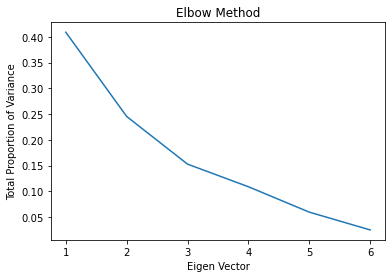

In [223]:
#Initializing Standardization Function
sc = StandardScaler()

#Initializing a Standardized Matrix of the Coefficient Table
Coeff_PCA_std = sc.fit_transform(Coefficient_Table)

#Condstructing a Covariance Matrix from the Standardized Matrix
Cov_Mat = np.cov(Coeff_PCA_std.T)

#Determining the Eigenvectors and the Eigenvalues from the Covariance Matrix
Eigen_Vals, Eigen_Vecs = np.linalg.eig(Cov_Mat)

#Determining the Percentage Explained Variances
Total = sum(Eigen_Vals)
Var_Exp = [(i / Total) for i in sorted(Eigen_Vals, reverse=True)]

#Creating the Elbow Plot showing the Proportion of Variance explained by the Eigenvectors
plt.plot(range(1,7), Var_Exp)
plt.title('Elbow Method')
plt.xlabel('Eigen Vector')
plt.ylabel('Proportion of Variance')
plt.show()

## Determining the Distance of the Points from the Line of Complete Systemic Risk

In [226]:
#Creating an Array which wil containg the average of the coefficient of all the points (the mean coordinates)
Average_Coeff = []

#Appending the Average Beta of each Risk Factor to the Average_Coeff Array
Average_Coeff.append(np.mean(np.array(Coefficient_Table['BOND'])))
Average_Coeff.append(np.mean(np.array(Coefficient_Table['SP500'])))
Average_Coeff.append(np.mean(np.array(Coefficient_Table['CREDIT'])))
Average_Coeff.append(np.mean(np.array(Coefficient_Table['CMDTY'])))
Average_Coeff.append(np.mean(np.array(Coefficient_Table['DVIX'])))
Average_Coeff.append(np.mean(np.array(Coefficient_Table['DHOUSE'])))

In [241]:
#Initializing the Normal(Perpendicular/Orthogonal) Vector to our Surface/Manifold of Complete Systemic Risk
Normal = [1, 1, 1, 1, 1, 1]

#Initializing the Vector between a Randomly Selected Point on the Manifold (1, 0, 0, 0, 0, 0) and the Average_Coeff Point
Random_Point = [1, 0, 0, 0, 0, 0]
Vector = np.subtract(Average_Coeff, Random_Point)

#Taking the Dot Product of the Normal Vector and the Arbitrary Vector to determine the distance of the point from the Manifold of Complete Systemic Risk
Distance = np.dot(Normal, Vector)

In [242]:
Distance

20.457789754371525

## Squared Weighted Systemic Risk

In [227]:
#Calculating the Squared Weighted Systemic Risk

#Initializing the Square Weighted Systemic Risk Variable
SquareWeighted_Systemic_Risk = 0

#Looping through the Coefficients and Incrementing the Variable by each Squared Coefficient
for i in Average_Coeff:
    #Incrementing by the Squared Coefficient
    SquareWeighted_Systemic_Risk += (i**2)

In [229]:
SquareWeighted_Systemic_Risk

447.3925576479083

## Measuring Clustering via the SD of the Points from the Mean Point

In [238]:
#Initializing the Array which will hold the Distances of all the Points from the Mean Point
distances = []

#Iterating through all Firms and their Coefficients in the Coefficients Table
for i in range(len(Coefficient_Table.BOND)):
    #Initialzing the Squared Differences for each Coefficient
    Bond_Distance = (Coefficient_Table.BOND[i] - Average_Coeff[0])**2
    SP500_Distance = (Coefficient_Table.SP500[i] - Average_Coeff[1])**2
    Credit_Distance = (Coefficient_Table.CREDIT[i] - Average_Coeff[2])**2
    CMDTY_Distance = (Coefficient_Table.CMDTY[i] - Average_Coeff[3])**2
    DVIX_Distance = (Coefficient_Table.DVIX[i] - Average_Coeff[4])**2
    DHouse_Distance = (Coefficient_Table.DHOUSE[i] - Average_Coeff[5])**2
    
    #Determining the Distance via all Coefficient Differences and the Pythagorean Theorem
    distance = np.sqrt((Bond_Distance + SP500_Distance + Credit_Distance + CMDTY_Distance + DVIX_Distance + DHouse_Distance))
    
    #Appending the distance to the distances array
    distances.append(distance)

#Calculating the SD of the Distances array (the smaller the SD the greater the Clustering and Systemic Risk)
sd_distances = np.std(distances)

In [240]:
sd_distances

41.94493551733694

## Running K-Means Clustering

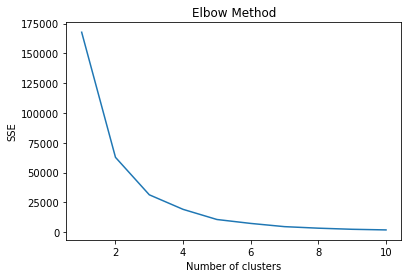

In [232]:
#Initializing the SSE Array Which Will Contain the Sum of Squared Errors for each Number of Clusters
SSE = []

#Running K-Means Clustering from 1 - 11 Clusters, and appending the SSE for each Number of Clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(Coefficient_Table)
    SSE.append(kmeans.inertia_)

#Creating the Elbow Plot showing the SSE for each Number of Clusters as a Contiguous Line
plt.plot(range(1, 11), SSE)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()